# Final ROSCOE scoring of CausalBench

## Preparing datasets 

### Merge qusetion ID, prompt, GPT4 predictions

In [13]:
# common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import re
from typing import Union, List, Tuple, Dict, Any, Optional

In [14]:
# read the overall result csv file
overall_result = pd.read_csv("raw_datasets/bern_cna_35_gpt4cot.csv")
overall_result.head()

,ID,descriptive_id,sensical,query_type,rung,phenomenon,simpson,truth,prompt,truth_norm,pred
0,4669,confounding_a_ett_gender_pay,-1,ett,3,confounding,False,yes,"Imagine a self-contained, hypothetical world w...",1,No
1,4046,collision_n_nie_nonsense0,0,nie,3,collision,False,no,"Imagine a self-contained, hypothetical world w...",0,No
2,1597,arrowhead_c_ett_floor_wet,1,ett,3,arrowhead,False,yes,"Imagine a self-contained, hypothetical world w...",1,Yes
3,2995,chain_a_nie_smoking_gene_cancer,-1,nie,3,chain,False,yes,"Imagine a self-contained, hypothetical world w...",1,No
4,9475,nondet-diamondcut_c_nde_smoking_frontdoor,1,nde,3,nondet-diamondcut,False,yes,"Imagine a self-contained, hypothetical world w...",1,Yes


In [15]:
# keep just ID and prompt columns
overall_result = overall_result[["ID", "descriptive_id", "prompt"]]
overall_result.head()

,ID,descriptive_id,prompt
0,4669,confounding_a_ett_gender_pay,"Imagine a self-contained, hypothetical world w..."
1,4046,collision_n_nie_nonsense0,"Imagine a self-contained, hypothetical world w..."
2,1597,arrowhead_c_ett_floor_wet,"Imagine a self-contained, hypothetical world w..."
3,2995,chain_a_nie_smoking_gene_cancer,"Imagine a self-contained, hypothetical world w..."
4,9475,nondet-diamondcut_c_nde_smoking_frontdoor,"Imagine a self-contained, hypothetical world w..."


In [16]:
# Read the csv file with pairs of prompts and GPT responses
prompt2gpt_response_lookup = pd.read_csv("raw_datasets/cache_gpt4_responses.csv")
prompt2gpt_response_lookup.head()

,pred,query
0,"No, the prisoner being alive cannot be guarant...",We know that captain commands causes rifleman1...
1,pred,query
2,"No, we cannot definitively conclude that the s...",principal's direction makes teacher1 and teach...
3,"No, based on the information provided, we cann...",principal's anger makes teacher1 and teacher2 ...
4,"No, the student might not necessarily be alive...",We know that captain commands causes professor...


In [17]:
# If the "pred" is not empty, then add the "pred" to the overall_result df.
# Using the "prompt" from overall_result df, look up the GPT4’s reasoning chain in the .cache_gpt4_responses.csv file (use "query" to look up "pred").

overall_result["pred"] = overall_result["prompt"].apply(
    lambda x: prompt2gpt_response_lookup[prompt2gpt_response_lookup["query"] == x][
        "pred"
    ].values[0]
    if len(
        prompt2gpt_response_lookup[prompt2gpt_response_lookup["query"] == x][
            "pred"
        ].values
    )
    > 0
    else np.nan
)
overall_result.head()

,ID,descriptive_id,prompt,pred
0,4669,confounding_a_ett_gender_pay,"Imagine a self-contained, hypothetical world w...",Step 1) Extract the causal graph: The causal g...
1,4046,collision_n_nie_nonsense0,"Imagine a self-contained, hypothetical world w...",Step 1) Extract the causal graph: The causal g...
2,1597,arrowhead_c_ett_floor_wet,"Imagine a self-contained, hypothetical world w...",Step 1) Extract the causal graph: The causal g...
3,2995,chain_a_nie_smoking_gene_cancer,"Imagine a self-contained, hypothetical world w...",Step 1) Extract the causal graph: The causal g...
4,9475,nondet-diamondcut_c_nde_smoking_frontdoor,"Imagine a self-contained, hypothetical world w...",Step 1) Extract the causal graph: The causal g...


### Create `id2truth_reasoning.json`

In [3]:
# Helper function to search a nested dictionary
def search_nested_dict(nested_dict, target_key):
    queue = [(nested_dict, key) for key in nested_dict]

    while queue:
        current_dict, key = queue.pop(0)

        if key == target_key:
            return current_dict[key]

        if isinstance(current_dict[key], type({})):
            for sub_key in current_dict[key]:
                queue.append((current_dict[key], sub_key))
    return None

In [4]:
# Read the txt template file
with open(
    "raw_datasets/ground_truth_reasoning_template.txt", "r", encoding="utf-8"
) as file:
    reasoning_template = file.read()
print(reasoning_template)

Step 1) Extract the causal graph: The causal graph expressed in the context is: "{graph}".

Step 2) Identify the query type: The query type of the above question is "{query_type}".

Step 3) Translate the query to an estimand: Based on the type of the causal query, the question can be translated to a formal estimand as: "{step1}".

Step 4) Collect all the available data: The available data are: "{given_info_formal}".

Step 5) Solve for the estimand: To solve for the estimand, we need to compute {step1_format}.

Using the causal graph, we can simplify the estimand to
{step1}
= {step2}

Using the available data, we can calculate:
{step2}
= {step3}
≈ {step4}

Since the estimate for the estimand is {step4}, the overall answer to the question is "{answer}".





In [5]:
# Load the json dataset as a list of nested dictionary
import json

with open("raw_datasets/bern_cna_35.json") as f:
    nested_dicts = json.load(f)

In [6]:
# Create a df with ID comlumn of same lenght as nested_dict
df = pd.DataFrame({"ID": [i for i in range(len(nested_dicts))]})
# Extract query_type, graph, step0, step1, step2, step3, step4, answer, given_info_formal, background, given_info, question from nested_dicts and add them to our df
df["query_type"] = df["ID"].apply(
    lambda x: search_nested_dict(nested_dicts[x], "query_type")
)
df["graph"] = df["ID"].apply(lambda x: search_nested_dict(nested_dicts[x], "graph"))
df["step0"] = df["ID"].apply(lambda x: search_nested_dict(nested_dicts[x], "step0"))
df["step1"] = df["ID"].apply(lambda x: search_nested_dict(nested_dicts[x], "step1"))
df["step2"] = df["ID"].apply(lambda x: search_nested_dict(nested_dicts[x], "step2"))
df["step3"] = df["ID"].apply(lambda x: search_nested_dict(nested_dicts[x], "step3"))
df["step4"] = df["ID"].apply(lambda x: search_nested_dict(nested_dicts[x], "step4"))
df["answer"] = df["ID"].apply(lambda x: search_nested_dict(nested_dicts[x], "answer"))
df["given_info_formal"] = df["ID"].apply(
    lambda x: search_nested_dict(nested_dicts[x], "given_info_formal")
)
df["background"] = df["ID"].apply(
    lambda x: search_nested_dict(nested_dicts[x], "background")
)
df["given_info"] = df["ID"].apply(
    lambda x: search_nested_dict(nested_dicts[x], "given_info")
)
df["question"] = df["ID"].apply(
    lambda x: search_nested_dict(nested_dicts[x], "question")
)
df.head()

,ID,query_type,graph,step0,step1,step2,step3,step4,answer,given_info_formal,background,given_info,question
0,0,ate,"V1->X,V1->Y,V2->X,X->Y",E[Y|do(X = 1)] − E[Y|do(X = 0)],P(Y=1|do(X=1)) - P(Y=1|do(X=1)),[P(Y=1|V2=1)-P(Y=1|V2=0)]/[P(X=1|V2=1)-P(X=1|V...,[0.5671622485-0.6026637459]/[0.2-0.14],-0.5917,no,"[P(Y=1|V2=0)=0.6026637459, P(Y=1|V2=1)=0.56716...","Imagine a self-contained, hypothetical world w...","For individuals served by water company A, the...",Will window-shopping increase the chance of ch...
1,1,ate,"V1->X,V1->Y,V2->X,X->Y",E[Y|do(X = 1)] − E[Y|do(X = 0)],P(Y=1|do(X=1)) - P(Y=1|do(X=1)),[P(Y=1|V2=1)-P(Y=1|V2=0)]/[P(X=1|V2=1)-P(X=1|V...,[0.39733441500000005-0.44394854770000003]/[0.9...,-0.1227,no,"[P(Y=1|V2=0)=0.44394854770000003, P(Y=1|V2=1)=...","Imagine a self-contained, hypothetical world w...","For applicants to competitive departments, the...",Will male gender increase the chance of no fre...
2,2,ate,"V1->X,V1->Y,V2->X,X->Y",E[Y|do(X = 1)] − E[Y|do(X = 0)],P(Y=1|do(X=1)) - P(Y=1|do(X=1)),[P(Y=1|V2=1)-P(Y=1|V2=0)]/[P(X=1|V2=1)-P(X=1|V...,[0.39733441500000005-0.44394854770000003]/[0.9...,-0.1227,no,"[P(Y=1|V2=0)=0.44394854770000003, P(Y=1|V2=1)=...","Imagine a self-contained, hypothetical world w...",For managers who do not sign termination lette...,Will CEO's decision to lay off the employee in...
3,3,ate,"V1->X,V1->Y,V2->X,X->Y",E[Y|do(X = 1)] − E[Y|do(X = 0)],P(Y=1|do(X=1)) - P(Y=1|do(X=1)),[P(Y=1|V2=1)-P(Y=1|V2=0)]/[P(X=1|V2=1)-P(X=1|V...,[0.2000484216-0.3129399888]/[0.8-0.5],-0.3763,no,"[P(Y=1|V2=0)=0.3129399888, P(Y=1|V2=1)=0.20004...","Imagine a self-contained, hypothetical world w...","For people experiencing no rain, the probabili...",Will rain season increase the chance of blood ...
4,4,ate,"V1->X,V1->Y,V2->X,X->Y",E[Y|do(X = 1)] − E[Y|do(X = 0)],P(Y=1|do(X=1)) - P(Y=1|do(X=1)),[P(Y=1|V2=1)-P(Y=1|V2=0)]/[P(X=1|V2=1)-P(X=1|V...,[0.5671622485-0.6026637459]/[0.2-0.14],-0.5917,no,"[P(Y=1|V2=0)=0.6026637459, P(Y=1|V2=1)=0.56716...","Imagine a self-contained, hypothetical world w...","For people with reduced crop yield per acre, t...",Will giving a handshake increase the chance of...


In [7]:
# Drop rows with null values in step0, step1, step2, step3, step4
print(len(df))
df = df.dropna(subset=["step0", "step1", "step2", "step3", "step4"])
print(len(df))

10686
4485


In [8]:
# Fill the reasoning_template with values from the dataframe
gt_reasonings = []
for index, row in df.iterrows():
    # Join the elements in the 'given_info_formal' column into a string
    given_info_formal_string = "; ".join(row["given_info_formal"])

    # Replace ' - ' with ' and ' in 'step1'
    step1_replaced = row["step1"].replace(" - ", " and ")

    # Create a dictionary from the row
    row_dict = row.to_dict()

    # Replace the 'given_info_formal' with the joined string
    row_dict["given_info_formal"] = given_info_formal_string

    # Replace the 'step1' with the replaced string
    row_dict["step1_format"] = step1_replaced

    # Now, format the template
    reasoning_template_filled = reasoning_template.format(**row_dict)
    # make dict of ID and reasoning_template_filled
    gt_reasonings.append(
        {"ID": row_dict["ID"], "gt_reasoning": reasoning_template_filled}
    )
df_gt_reasonings = pd.DataFrame(gt_reasonings)
df_gt_reasonings.head()

,ID,gt_reasoning
0,0,Step 1) Extract the causal graph: The causal g...
1,1,Step 1) Extract the causal graph: The causal g...
2,2,Step 1) Extract the causal graph: The causal g...
3,3,Step 1) Extract the causal graph: The causal g...
4,4,Step 1) Extract the causal graph: The causal g...


In [9]:
# Save the gt_reasonings as a jsonl file
with open("raw_datasets/id2truth_reasoning.jsonl", "w") as f:
    for item in gt_reasonings:
        f.write(json.dumps(item) + "\n")

### 2K input data samples as a CSV with (ID, descriptive_id, background, given_info, question, ground_truth_reasoning, model_reasoning)

In [10]:
df = df.merge(df_gt_reasonings, on="ID")
# drop query_type	graph	step0	step1	step2	step3	step4 answer given_info_formal
df = df.drop(
    columns=[
        "query_type",
        "graph",
        "step0",
        "step1",
        "step2",
        "step3",
        "step4",
        "answer",
        "given_info_formal",
    ]
)

df.head()

,ID,background,given_info,question,gt_reasoning
0,0,"Imagine a self-contained, hypothetical world w...","For individuals served by water company A, the...",Will window-shopping increase the chance of ch...,Step 1) Extract the causal graph: The causal g...
1,1,"Imagine a self-contained, hypothetical world w...","For applicants to competitive departments, the...",Will male gender increase the chance of no fre...,Step 1) Extract the causal graph: The causal g...
2,2,"Imagine a self-contained, hypothetical world w...",For managers who do not sign termination lette...,Will CEO's decision to lay off the employee in...,Step 1) Extract the causal graph: The causal g...
3,3,"Imagine a self-contained, hypothetical world w...","For people experiencing no rain, the probabili...",Will rain season increase the chance of blood ...,Step 1) Extract the causal graph: The causal g...
4,4,"Imagine a self-contained, hypothetical world w...","For people with reduced crop yield per acre, t...",Will giving a handshake increase the chance of...,Step 1) Extract the causal graph: The causal g...


In [18]:
df = df.merge(overall_result, on="ID")
df.head()

,ID,background,given_info,question,ground_truth_reasoning,descriptive_id,prompt,pred
0,0,"Imagine a self-contained, hypothetical world w...","For individuals served by water company A, the...",Will window-shopping increase the chance of ch...,Step 1) Extract the causal graph: The causal g...,IV_a_ate_water_cholera,"Imagine a self-contained, hypothetical world w...",Step 1) Extract the causal graph: The causal g...
1,2,"Imagine a self-contained, hypothetical world w...",For managers who do not sign termination lette...,Will CEO's decision to lay off the employee in...,Step 1) Extract the causal graph: The causal g...,IV_a_ate_firing_employee,"Imagine a self-contained, hypothetical world w...",Step 1) Extract the causal graph: The causal g...
2,7,"Imagine a self-contained, hypothetical world w...","For individuals served by water company A, the...",Will pure water increase the chance of brunett...,Step 1) Extract the causal graph: The causal g...,IV_a_ate_water_cholera,"Imagine a self-contained, hypothetical world w...",Step 1) Extract the causal graph: The causal g...
3,14,"Imagine a self-contained, hypothetical world w...","For applicants to competitive departments, the...",Will head scratching increase the chance of ad...,Step 1) Extract the causal graph: The causal g...,IV_a_ate_gender_admission_state,"Imagine a self-contained, hypothetical world w...",Step 1) Extract the causal graph: The causal g...
4,15,"Imagine a self-contained, hypothetical world w...","For people experiencing no rain, the probabili...",Will mud eating increase the chance of wet floor?,Step 1) Extract the causal graph: The causal g...,IV_a_ate_floor_wet,"Imagine a self-contained, hypothetical world w...",Step 1) Extract the causal graph: The causal g...


In [19]:
# rename gt_reasoning to ground_truth_reasoning
df = df.rename(columns={"gt_reasoning": "ground_truth_reasoning"})
# rename pred to model_reasoning
df = df.rename(columns={"pred": "model_reasoning"})
# Order as (ID, descriptive_id, background, given_info, question, ground_truth_reasoning, model_reasoning)
df_samples = df[
    [
        "ID",
        "descriptive_id",
        "background",
        "given_info",
        "question",
        "ground_truth_reasoning",
        "model_reasoning",
    ]
]
# Keep first 2000 rows
df_samples = df_samples[:2000]
df_samples.head()

,ID,descriptive_id,background,given_info,question,ground_truth_reasoning,model_reasoning
0,0,IV_a_ate_water_cholera,"Imagine a self-contained, hypothetical world w...","For individuals served by water company A, the...",Will window-shopping increase the chance of ch...,Step 1) Extract the causal graph: The causal g...,Step 1) Extract the causal graph: The causal g...
1,2,IV_a_ate_firing_employee,"Imagine a self-contained, hypothetical world w...",For managers who do not sign termination lette...,Will CEO's decision to lay off the employee in...,Step 1) Extract the causal graph: The causal g...,Step 1) Extract the causal graph: The causal g...
2,7,IV_a_ate_water_cholera,"Imagine a self-contained, hypothetical world w...","For individuals served by water company A, the...",Will pure water increase the chance of brunett...,Step 1) Extract the causal graph: The causal g...,Step 1) Extract the causal graph: The causal g...
3,14,IV_a_ate_gender_admission_state,"Imagine a self-contained, hypothetical world w...","For applicants to competitive departments, the...",Will head scratching increase the chance of ad...,Step 1) Extract the causal graph: The causal g...,Step 1) Extract the causal graph: The causal g...
4,15,IV_a_ate_floor_wet,"Imagine a self-contained, hypothetical world w...","For people experiencing no rain, the probabili...",Will mud eating increase the chance of wet floor?,Step 1) Extract the causal graph: The causal g...,Step 1) Extract the causal graph: The causal g...


In [20]:
# Shuffle the df_samples
df_samples = df_samples.sample(frac=1).reset_index(drop=True)
df_samples.head()

,ID,descriptive_id,background,given_info,question,ground_truth_reasoning,model_reasoning
0,1404,arrowhead_a_ett_firing_employee,"Imagine a self-contained, hypothetical world w...","For people who are not meowing, the probabilit...","For people who are meowing, would it be more l...",Step 1) Extract the causal graph: The causal g...,Step 1) Extract the causal graph: The causal g...
1,7190,mediation_n_nde_nonsense3,"Imagine a self-contained, hypothetical world w...","For those who are not rujz and are not kwox, t...",If we disregard the mediation effect through k...,Step 1) Extract the causal graph: The causal g...,Step 1) Extract the causal graph: The causal g...
2,2759,chain_c_ett_smoking_frontdoor,"Imagine a self-contained, hypothetical world w...","For nonsmokers, the probability of lung cancer...","For smokers, would it be more likely to see lu...",Step 1) Extract the causal graph: The causal g...,Step 1) Extract the causal graph: The causal g...
3,1538,arrowhead_n_ett_nonsense8,"Imagine a self-contained, hypothetical world w...","For those who are not hupx, the probability of...","For those who are hupx, would it be more likel...",Step 1) Extract the causal graph: The causal g...,Step 1) Extract the causal graph: The causal g...
4,6376,mediation_a_ate_gender_pay,"Imagine a self-contained, hypothetical world w...","For individuals who are not male, the probabil...",Will male gender increase the chance of thick ...,Step 1) Extract the causal graph: The causal g...,Step 1) Extract the causal graph: The causal g...


In [95]:
# Save the df_samples as a csv file
df_samples.to_csv("raw_datasets/2k_roscoe_samples.csv", index=False)

### Create bern_cna_35_true_reasoning.json

In [43]:
# Read the gt_reasonings_df as a pandas dataframe
gt_reasonings_df = pd.read_json("raw_datasets/id2truth_reasoning.jsonl", lines=True)
gt_reasonings_df.head()

,ID,gt_reasoning
0,0,Step 1) Extract the causal graph: The causal g...
1,1,Step 1) Extract the causal graph: The causal g...
2,2,Step 1) Extract the causal graph: The causal g...
3,3,Step 1) Extract the causal graph: The causal g...
4,4,Step 1) Extract the causal graph: The causal g...


In [54]:
# Merge overall_result_no_null and gt_reasonings_df on ID
overall_result_gt = overall_result.merge(df_gt_reasonings, on="ID")
overall_result_gt.head()

,ID,descriptive_id,prompt,pred,gt_reasoning
0,4669,confounding_a_ett_gender_pay,"Imagine a self-contained, hypothetical world w...",Step 1) Extract the causal graph: The causal g...,Step 1) Extract the causal graph: The causal g...
1,1597,arrowhead_c_ett_floor_wet,"Imagine a self-contained, hypothetical world w...",Step 1) Extract the causal graph: The causal g...,Step 1) Extract the causal graph: The causal g...
2,2995,chain_a_nie_smoking_gene_cancer,"Imagine a self-contained, hypothetical world w...",Step 1) Extract the causal graph: The causal g...,Step 1) Extract the causal graph: The causal g...
3,9475,nondet-diamondcut_c_nde_smoking_frontdoor,"Imagine a self-contained, hypothetical world w...",Step 1) Extract the causal graph: The causal g...,Step 1) Extract the causal graph: The causal g...
4,6328,mediation_a_ate_obesity_mortality,"Imagine a self-contained, hypothetical world w...",Step 1) Extract the causal graph: The causal g...,Step 1) Extract the causal graph: The causal g...


In [133]:
# Add a new field in the gt_reasoning in nested_dicts
updated_nested_dicts = nested_dicts
for index, row in gt_reasonings_df.iterrows():
    updated_nested_dicts[row["ID"]]["truth_reasoning"] = row["gt_reasoning"]
updated_nested_dicts[0]

{'ID': 0,
 'descriptive_id': 'IV_a_ate_water_cholera',
 'sensical': -1,
 'story_id': 'water_cholera',
 'background': 'Imagine a self-contained, hypothetical world with only the following conditions, and without any unmentioned factors or causal relationships: Low poverty rate has a direct effect on window-shopping and cholera prevention. Water company B has a direct effect on window-shopping. Window-shopping has a direct effect on cholera prevention. Poverty level of the region is unobserved.',
 'given_info': 'For individuals served by water company A, the probability of cholera prevention is 60.27%. For individuals served by water company B, the probability of cholera prevention is 56.72%. For individuals served by water company A, the probability of window-shopping is 14.00%. For individuals served by water company B, the probability of window-shopping is 20.00%.',
 'question': 'Will window-shopping increase the chance of cholera prevention?',
 'variable_mapping': {'V2name': 'water c

In [135]:
# Save nested_dicts as a json file
with open("raw_datasets/bern_cna_35_true_reasoning.json", "w") as f:
    json.dump(updated_nested_dicts, f)

In [136]:
# load bern_cna_35_true_reasoning.json
with open("raw_datasets/bern_cna_35_true_reasoning.json") as f:
    nested_dicts1 = json.load(f)

# count number of entries with truth_reasoning
count = 0
for i in range(len(nested_dicts1)):
    if "truth_reasoning" in nested_dicts1[i]:
        count += 1
print(count)

4485


## Formatting for ROSCOE

In [113]:
def prepare_json_for_roscoe(
    df: pd.DataFrame,
    prompt_column: str,
    gpt_column: str,
    out_name: str,
    gt_column: Union[str, None] = None,
    id_column: Union[str, None] = None,
) -> None:
    df_out = df[[prompt_column, gpt_column]]
    df_out.rename(columns={gpt_column: "gpt-3", prompt_column: "premise"}, inplace=True)
    # As strange as it sounds, hypotesis column is used for ground truth, left empty otherwise
    if gt_column is not None:
        df_out["hypothesis"] = (
            "IGNORE THIS. Ground truth here for reference. " + df[gt_column]
        )
    else:
        df_out["hypothesis"] = " "
    if id_column is not None:
        df_out["ID"] = df[id_column]

    df_out.to_json("datasets/" + out_name + ".jsonl", orient="records", lines=True)
    return None

In [114]:
prepare_json_for_roscoe(
    overall_result_gt,
    "prompt",
    "pred",
    "cb_gt",
    gt_column="gt_reasoning",
    id_column="ID",
)

/local/home/zhijing/proj/tools/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-113-8343e09033f3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out["hypothesis"] = (


## Run ROSCOE

From the ParlAI root repository folder: 
```python
python projects/roscoe/roscoe.py -t sim_sce -m facebook/roscoe-512-roberta-base --dataset-path ../CausalLLMs/roscoe_exp/datasets --datasets cb2
```

**IMPORTANT**: to obtain also the supervised scores, the dataset name should inculde gt e.g. name your dataset `cb_gt.jsonl` and pass `cb_gt` as an argument

## Analysis and visualizations

In [2]:
import re


def clean_tsv(filename):
    # Open the file in read mode
    with open(filename, "r") as file:
        # Read the file contents and store it in a variable
        file_contents = file.read()

    # Remove all excessive white spaces
    clean_contents = re.sub(" +", " ", file_contents)

    # Open the file in write mode
    with open(filename, "w") as file:
        # Write the cleaned contents back to the file
        file.write(clean_contents)

In [3]:
filename = "scores/roscoe-512-roberta-base/scores_cb_gt.tsv"
clean_tsv(filename)
df_scores = pd.read_table(filename, sep=" ", header=0)
df_scores.drop(columns=["ID"], inplace=True)
df_scores.head()

,faithfulness,informativeness_step,informativeness_chain,faithfulness_ww,repetition_word,repetition_step,reasoning_alignment,external_hallucination,redundancy,common_sense_error,missing_step,semantic_coverage_step,semantic_coverage_chain,discourse_representation,coherence_step_vs_step,perplexity_step,perplexity_chain,perplexity_step_max,grammar_step,grammar_step_max
0,0.865416,0.881515,0.878924,0.941392,0.000664,0.000972,0.910291,0.971952,0.837472,0.963563,0.863721,0.988618,0.976743,0.053344,0.001588,0.033433,0.229935,0.003475,0.898316,0.071475
1,0.895721,0.885935,0.869218,0.963256,0.038761,0.030115,0.909640,0.949369,0.688231,0.936597,0.744714,0.990090,0.968069,0.002219,0.008872,0.027586,0.103354,0.014396,0.917724,0.453010
2,0.897416,0.882714,0.927187,0.956241,0.047384,0.026998,0.938737,0.984151,0.890182,0.945545,0.765114,0.987028,0.963422,0.019033,0.366958,0.023175,0.073830,0.009735,0.982251,0.966039
3,0.879447,0.873381,0.843166,0.937912,0.001001,0.001493,0.921944,0.973528,0.805752,0.963072,0.817615,0.997951,0.977082,0.008005,0.002195,0.028516,0.281842,0.002648,0.972977,0.928271
4,0.875076,0.874939,0.894124,0.953991,0.017771,0.006509,0.911714,0.967215,0.782471,0.943768,0.768904,0.990781,0.988915,0.185167,0.935053,0.022331,0.149075,0.008327,0.940080,0.815242


In [4]:
# Bases stats
df_scores.describe()

,faithfulness,informativeness_step,informativeness_chain,faithfulness_ww,repetition_word,repetition_step,reasoning_alignment,external_hallucination,redundancy,common_sense_error,missing_step,semantic_coverage_step,semantic_coverage_chain,discourse_representation,coherence_step_vs_step,perplexity_step,perplexity_chain,perplexity_step_max,grammar_step,grammar_step_max
count,2060.000000,2060.000000,2060.000000,2060.000000,2.060000e+03,2.060000e+03,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000
mean,0.886854,0.882156,0.884633,0.950420,2.100352e-02,1.602076e-02,0.917035,0.965110,0.796490,0.947990,0.779722,0.986212,0.980114,0.064945,0.138975,0.024006,0.173160,0.004901,0.927027,0.532154
std,0.017367,0.013023,0.031672,0.010694,1.642114e-02,1.440047e-02,0.013080,0.022934,0.054363,0.011096,0.030886,0.009364,0.010066,0.134232,0.266597,0.007880,0.073784,0.004575,0.042751,0.354994
min,0.827657,0.830489,0.757025,0.920474,-2.185504e-08,-2.980232e-08,0.857712,0.837970,0.563812,0.860717,0.578374,0.948867,0.926305,0.000282,0.000246,0.003378,0.045844,0.000034,0.772040,0.024495
25%,0.876370,0.873817,0.871764,0.941281,4.992350e-03,2.706788e-03,0.909166,0.959070,0.767450,0.941202,0.759680,0.980018,0.977027,0.005735,0.003249,0.018391,0.105507,0.000954,0.899354,0.121863
50%,0.887714,0.882714,0.890468,0.946740,1.801540e-02,1.195033e-02,0.917277,0.972198,0.803324,0.947723,0.776195,0.987576,0.981845,0.013369,0.005051,0.022907,0.173994,0.002814,0.932403,0.647391
75%,0.899876,0.892152,0.904884,0.959931,3.718182e-02,2.604974e-02,0.925175,0.980181,0.833666,0.956284,0.800079,0.993863,0.987518,0.048062,0.071185,0.028760,0.226523,0.008469,0.962364,0.845591
max,0.928732,0.915545,0.964168,0.972124,5.026206e-02,5.820368e-02,0.952447,0.992707,0.920725,0.977347,0.884555,0.999995,0.994753,0.672213,0.943976,0.067336,0.424621,0.019938,0.988930,0.985590


In [9]:
# get columns and remove "_"
cols = df_scores.columns
cols = [col.replace("_", " ") for col in cols]
# rename columns
df_scores.columns = cols
df_scores.head()

,faithfulness,informativeness step,informativeness chain,faithfulness ww,repetition word,repetition step,reasoning alignment,external hallucination,redundancy,common sense error,missing step,semantic coverage step,semantic coverage chain,discourse representation,coherence step vs step,perplexity step,perplexity chain,perplexity step max,grammar step,grammar step max
0,0.865416,0.881515,0.878924,0.941392,0.000664,0.000972,0.910291,0.971952,0.837472,0.963563,0.863721,0.988618,0.976743,0.053344,0.001588,0.033433,0.229935,0.003475,0.898316,0.071475
1,0.895721,0.885935,0.869218,0.963256,0.038761,0.030115,0.909640,0.949369,0.688231,0.936597,0.744714,0.990090,0.968069,0.002219,0.008872,0.027586,0.103354,0.014396,0.917724,0.453010
2,0.897416,0.882714,0.927187,0.956241,0.047384,0.026998,0.938737,0.984151,0.890182,0.945545,0.765114,0.987028,0.963422,0.019033,0.366958,0.023175,0.073830,0.009735,0.982251,0.966039
3,0.879447,0.873381,0.843166,0.937912,0.001001,0.001493,0.921944,0.973528,0.805752,0.963072,0.817615,0.997951,0.977082,0.008005,0.002195,0.028516,0.281842,0.002648,0.972977,0.928271
4,0.875076,0.874939,0.894124,0.953991,0.017771,0.006509,0.911714,0.967215,0.782471,0.943768,0.768904,0.990781,0.988915,0.185167,0.935053,0.022331,0.149075,0.008327,0.940080,0.815242


In [22]:
# Bases stats, drop count
stats = df_scores.describe()
# transpose
stats = stats.T.drop(columns=["count"])
# round to 2 decimals
stats = stats.round(2)
stats.head()
# print latex
print(stats.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  mean &   std &   min &   25\% &   50\% &   75\% &   max \\
\midrule
faithfulness             &  0.89 &  0.02 &  0.83 &  0.88 &  0.89 &  0.90 &  0.93 \\
informativeness step     &  0.88 &  0.01 &  0.83 &  0.87 &  0.88 &  0.89 &  0.92 \\
informativeness chain    &  0.88 &  0.03 &  0.76 &  0.87 &  0.89 &  0.90 &  0.96 \\
faithfulness ww          &  0.95 &  0.01 &  0.92 &  0.94 &  0.95 &  0.96 &  0.97 \\
repetition word          &  0.02 &  0.02 & -0.00 &  0.00 &  0.02 &  0.04 &  0.05 \\
repetition step          &  0.02 &  0.01 & -0.00 &  0.00 &  0.01 &  0.03 &  0.06 \\
reasoning alignment      &  0.92 &  0.01 &  0.86 &  0.91 &  0.92 &  0.93 &  0.95 \\
external hallucination   &  0.97 &  0.02 &  0.84 &  0.96 &  0.97 &  0.98 &  0.99 \\
redundancy               &  0.80 &  0.05 &  0.56 &  0.77 &  0.80 &  0.83 &  0.92 \\
common sense error       &  0.95 &  0.01 &  0.86 &  0.94 &  0.95 &  0.96 &  0.98 \\
missing step             &  0.78 &  0.03 &  0.58 & 

array([[<AxesSubplot:title={'center':'faithfulness'}>,
        <AxesSubplot:title={'center':'informativeness step'}>,
        <AxesSubplot:title={'center':'informativeness chain'}>],
       [<AxesSubplot:title={'center':'faithfulness ww'}>,
        <AxesSubplot:title={'center':'repetition word'}>,
        <AxesSubplot:title={'center':'repetition step'}>],
       [<AxesSubplot:title={'center':'reasoning alignment'}>,
        <AxesSubplot:title={'center':'external hallucination'}>,
        <AxesSubplot:title={'center':'redundancy'}>],
       [<AxesSubplot:title={'center':'common sense error'}>,
        <AxesSubplot:title={'center':'missing step'}>,
        <AxesSubplot:title={'center':'semantic coverage step'}>],
       [<AxesSubplot:title={'center':'semantic coverage chain'}>,
        <AxesSubplot:title={'center':'discourse representation'}>,
        <AxesSubplot:title={'center':'coherence step vs step'}>],
       [<AxesSubplot:title={'center':'perplexity step'}>,
        <AxesSubplot:t

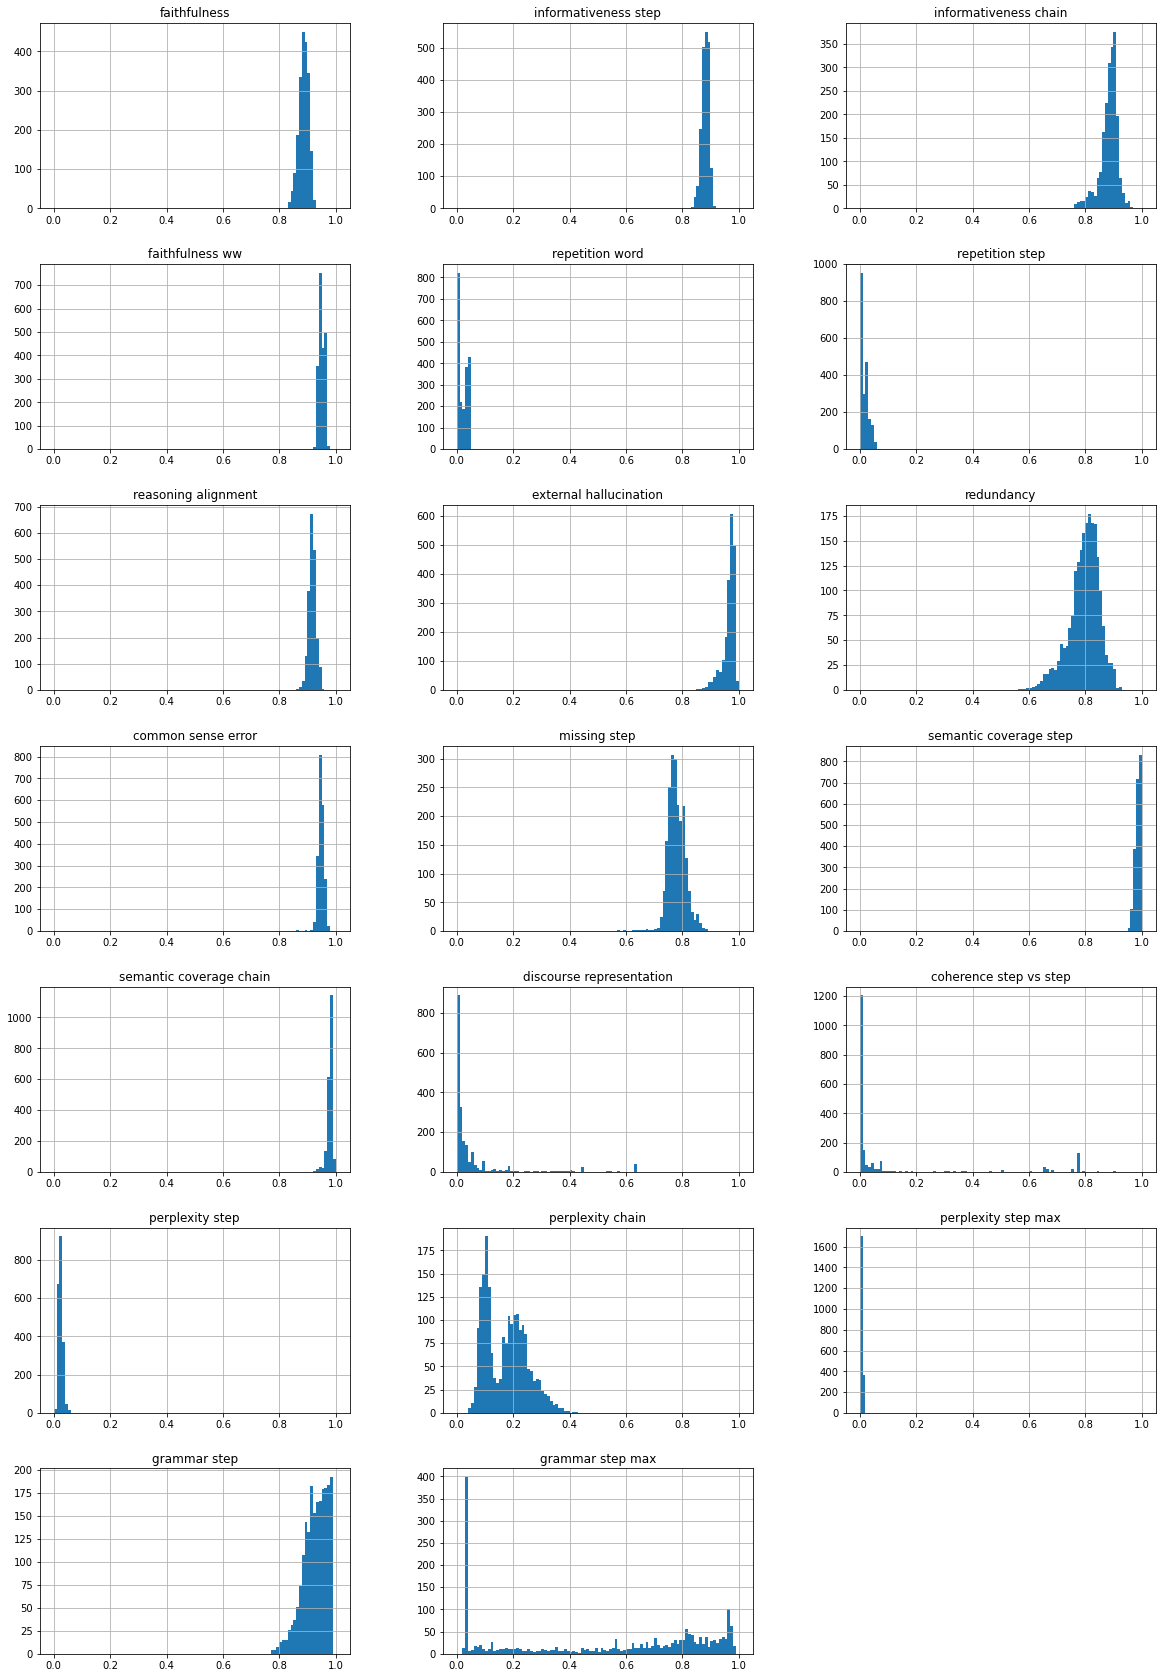

In [17]:
# histogram of the scores, bins=50, range=(0,1), figsize=(20,20), layout=(2,2)

df_scores.hist(bins=100, range=(0, 1), figsize=(20, 30), layout=(7, 3))

## TESTING AUTOMTED SCRIPT


In [81]:
import time

while True:
    if not os.path.exists("./delete_me_to_stop_script.txt"):
        break

    try:
        print("Running...")
    except Exception as e:
        print(f"An error occurred: {e}")
    # Wait for 1 hour for next update
    time.sleep(5)

Running...
Running...
Running...


In [143]:
import requests

file_id = "1mIOdGwwhZyGTNOBgc5lyWeU3E_ve5xAB"
download_url = f"https://drive.google.com/uc?export=download&id={file_id}"

response = requests.get(download_url)

with open("bern_cna_35_gpt4cot.csv", "wb") as ofile:
    ofile.write(response.content)